# PSPNet + PoseNet + ACGPN

## Dataset: VITON dataset 
    This dataset contains 16,253 image pairs, further splitting into a training set of 14,221 paris and a testing set of 2,032 pairs.

## Uploading Dataset

In [1]:
!mkdir Dataset

#### Uploading dataset in (color, edge, mask, colormask)

In [2]:
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_color Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_edge Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_mask Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_colormask Dataset

#### Uploading TestData (image, pose, label)

In [3]:
#TestData
!cp -r /kaggle/input/virtual-fit-test-dataset/Dataset/test_img Dataset
!cp -r /kaggle/input/virtual-fit-test-dataset/Dataset/test_pose Dataset
!cp -r /kaggle/input/virtual-fit-test-dataset/Dataset/test_label Dataset

In [4]:
import os
print('test image    :', len(os.listdir('./Dataset/test_img')))   # test image (person with clothes)
print('test pose     :', len(os.listdir('./Dataset/test_pose')))  # pose keypoints per test image
print('test label    :', len(os.listdir('./Dataset/test_label'))) # label (dark frame) of test image (for pose-map)
print('test color    :', len(os.listdir('./Dataset/test_color')))     # color clothes  
print('test edge     :', len(os.listdir('./Dataset/test_edge')))      # edge of clothes
print('test mask     :', len(os.listdir('./Dataset/test_mask')))      # test mask        
print('test colormask:', len(os.listdir('./Dataset/test_colormask'))) # test colormask

test image    : 2033
test pose     : 2033
test label    : 2033
test color    : 2032
test edge     : 2032
test mask     : 12000
test colormask: 10000


# Semantic Segmentation using PSPNet

In [5]:
!git clone https://github.com/rkuo2000/semantic-segmentation-pytorch 
%cd semantic-segmentation-pytorch

Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 530 (delta 185), reused 174 (delta 174), pack-reused 337
Receiving objects: 100% (530/530), 37.47 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/kaggle/working/semantic-segmentation-pytorch


### Importing Important Libs

In [6]:
from torchvision import transforms
from segmentation.data_loader.segmentation_dataset import SegmentationDataset
from segmentation.data_loader.transform import Rescale, ToTensor
from segmentation.trainer import Trainer
from segmentation.predict import *
from segmentation.models import all_models
from util.logger import Logger

In [7]:
import os
from torchvision import transforms

from segmentation.data_loader.segmentation_dataset import SegmentationDataset
from segmentation.data_loader.transform import Rescale, ToTensor
from segmentation.trainer import Trainer
from segmentation.predict import *
from segmentation.models import all_models
from util.logger import Logger
import matplotlib.pyplot as plt

In [8]:
model_name = "pspnet_mobilenet_v2"
device = 'cuda'
batch_size = 4
n_classes = 34 
check_point_stride = 1 # store checkpoints every 1 epoch   
image_axis_minimum_size = 200

num_epochs = 1    # 1 for 1st training
                  # n for retraining
                  # 0 for detect-only
pretrained = False# True  for num_epochs=1 without logger.load_model below
                  # False for num_epochs=n with    logger.load_model below
                  # False for detect-only  with    logger.load_model below
fixed_feature = False

logger = Logger(model_name=model_name, data_name='example')

In [9]:
train_images = '/kaggle/input/viton-dataset/ACGPN_TrainData/train_img'
train_labled = '/kaggle/input/viton-dataset/ACGPN_TrainData/train_label'
test_images  = '/kaggle/input/viton-dataset/ACGPN_TestData/test_img'
test_labeled = '/kaggle/input/viton-dataset/ACGPN_TestData/test_label'

In [10]:
compose = transforms.Compose([Rescale(image_axis_minimum_size),ToTensor()])

train_datasets = SegmentationDataset(train_images, train_labled, n_classes, compose)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, drop_last=True)

test_datasets = SegmentationDataset(test_images, test_labeled, n_classes, compose)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=True, drop_last=True)

100%|████████████████████████████████████| 14221/14221 [01:48<00:00, 130.67it/s]


Dataset verified! 


100%|██████████████████████████████████████| 2032/2032 [00:15<00:00, 131.88it/s]

Dataset verified! 


### Build Model

In [11]:
### Model
model = all_models.model_from_name[model_name](n_classes, batch_size, 
                                               pretrained=pretrained, 
                                               fixed_feature=fixed_feature)
model.to(device)

# Optimizers
if pretrained and fixed_feature: #fine-tunning
    params_to_update = model.parameters()
    print("Params to learn:")
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
    optimizer = torch.optim.Adadelta(params_to_update)
else:
    optimizer = torch.optim.Adadelta(model.parameters())

In [12]:
!mkdir -p runs/models/pspnet_mobilenet_v2/example
!cp  /kaggle/input/pspnet-viton-checkpoints/epoch_0 runs/models/pspnet_mobilenet_v2/example

logger.load_model(model, 'epoch_0') 

### Train Model

In [13]:
## Train
trainer = Trainer(model, optimizer, logger, num_epochs, train_loader, test_loader, check_point_epoch_stride=check_point_stride)
trainer.train()
print(os.listdir('runs/models/'+model_name+'/example'))

Train: 100%|█████████████████████████████████████| 1/1 [14:51<00:00, 891.59s/it]

['epoch_0']


### Saving And Loading Model

In [14]:
## Loader
compose = transforms.Compose([Rescale(image_axis_minimum_size),ToTensor()])

In [15]:
model_name = "pspnet_mobilenet_v2"
device = 'cuda'
batch_size = 4
n_classes = 34 
check_point_stride = 1    
image_axis_minimum_size = 200

num_epochs = 0    
pretrained = False
fixed_feature = False

logger = Logger(model_name=model_name, data_name='example')

### Segmentation Model

In [16]:
### Model
model = all_models.model_from_name[model_name](n_classes, batch_size, 
                                               pretrained=pretrained, 
                                               fixed_feature=fixed_feature)
model.to(device)

PSPnet(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU6(inplace=True)
      (5): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)


In [17]:
#Saving and Loading Checkpoints
!mkdir -p runs/models/pspnet_mobilenet_v2/example
!cp /kaggle/input/pspnet-viton-checkpoints/epoch_1 runs/models/pspnet_mobilenet_v2/example


logger.load_model(model,'epoch_1')

## Detect label (semantic segmentation)

In [18]:
test_img_file   = '../Dataset/test_img/000001_0.jpg'
test_label_file = '../Dataset/test_label/000001_0.png'

### Pridicted Values

In [19]:
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.6369,  6.9893,  7.7773,  ...,  7.0304,  6.4383,  5.7944],
          [ 7.0241,  9.0116, 10.0662,  ...,  9.0546,  8.1594,  7.0159],
          [ 7.6942,  9.8691, 11.0608,  ...,  9.7190,  8.8642,  7.5066],
          ...,
          [ 4.7826,  5.0922,  5.3026,  ...,  4.6390,  4.4390,  4.5465],
          [ 4.5402,  4.7715,  4.9871,  ...,  4.3301,  4.1649,  4.3449],
          [ 4.7268,  4.8686,  5.0084,  ...,  4.2237,  4.1400,  4.3823]],

         [[-0.5709, -0.3790, -0.3937,  ...,  0.4254,  0.2749, -0.2621],
          [-0.4722, -1.0107, -1.2103,  ...,  0.3943,  0.5001,  0.0808],
          [-0.6051, -1.1786, -1.4284,  ...,  0.4548,  0.5494,  0.3408],
          ...,
          [-1.2915, -1.6945, -1.8564,  ..., -2.7400, -2.3691, -1.8857],
          [-1.3944, -1.7969, -1.9486,  ..., -2.8303, -2.4434, -1.9773],
          [-1.4873, -1.6807, -1.7738,  ..., -2.4657, -2.2050, -1.7952]],

         [[-3.4362, -3.5146, -3.5480,  ..., -3.4710, -3.4246, -3.4419],
          [-3.6318, -4.0731, -

## Show image & its label (segmentation)

In [20]:
from IPython.display import Image

### Test Image 

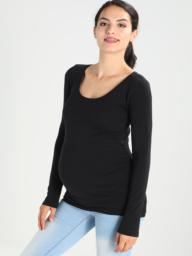

In [21]:
Image(test_img_file)

###  Result test color label

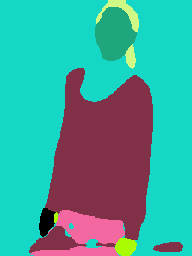

In [22]:
Image(test_label_file)

### Result In Test Gray Label

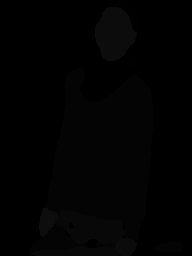

In [23]:
Image(test_label_file.replace('.png','_gray.png'))

In [24]:
test_img_file   = '../Dataset/test_img/000020_0.jpg'
test_label_file = '../Dataset/test_label/000020_0.png'
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.3058,  6.3921,  7.1293,  ...,  7.2194,  6.4939,  5.7658],
          [ 6.4311,  8.1073,  9.0448,  ...,  9.2999,  8.2666,  7.0143],
          [ 7.0067,  8.8342,  9.8100,  ..., 10.0014,  8.9596,  7.5027],
          ...,
          [ 5.0331,  5.4925,  5.5929,  ...,  4.3080,  4.0972,  4.3693],
          [ 4.7659,  5.1059,  5.2499,  ...,  4.0221,  3.8680,  4.1811],
          [ 4.8504,  5.0837,  5.1922,  ...,  4.0476,  3.9749,  4.2952]],

         [[-0.5478, -0.2693, -0.2463,  ...,  0.5181,  0.3832, -0.2031],
          [-0.3587, -0.6419, -0.7530,  ...,  0.5366,  0.6163,  0.1559],
          [-0.3937, -0.7827, -0.8223,  ...,  0.5841,  0.6687,  0.4130],
          ...,
          [-1.0003, -1.3453, -1.5362,  ..., -2.4759, -2.1457, -1.7636],
          [-1.0735, -1.3710, -1.5195,  ..., -2.5609, -2.1931, -1.8170],
          [-1.2646, -1.3593, -1.4030,  ..., -2.2318, -1.9749, -1.6482]],

         [[-3.3908, -3.3908, -3.4236,  ..., -3.5314, -3.4555, -3.4507],
          [-3.5126, -3.7814, -

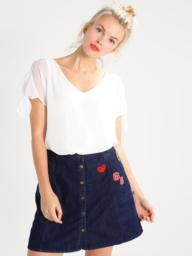

In [25]:
Image(test_img_file)


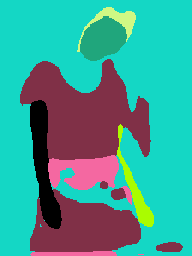

In [26]:
Image(test_label_file)


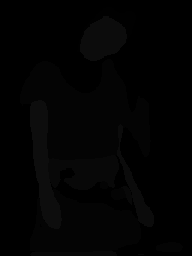

In [27]:
Image(test_label_file.replace('.png','_gray.png'))

In [28]:
test_img_file   = '../Dataset/test_img/003821_0.jpg'
test_label_file = '../Dataset/test_label/003821_0.png'
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.6219,  6.9879,  7.8248,  ...,  7.4219,  6.6676,  5.9162],
          [ 6.9969,  9.0459, 10.1715,  ...,  9.6236,  8.6120,  7.2688],
          [ 7.6504,  9.8718, 11.1685,  ..., 10.5116,  9.4286,  7.8304],
          ...,
          [ 4.3188,  4.3014,  4.3174,  ...,  3.6954,  3.6334,  3.9284],
          [ 4.1219,  4.0345,  4.0869,  ...,  3.4310,  3.3901,  3.7936],
          [ 4.4235,  4.3461,  4.3486,  ...,  3.6032,  3.6254,  4.0236]],

         [[-0.4456, -0.1606, -0.1414,  ...,  0.6547,  0.5752, -0.1002],
          [-0.2789, -0.7037, -0.8289,  ...,  0.7272,  0.7793,  0.3668],
          [-0.3939, -0.8053, -0.9563,  ...,  0.7836,  0.8534,  0.6281],
          ...,
          [-1.3384, -1.6855, -1.9119,  ..., -3.1216, -2.7454, -2.1084],
          [-1.4597, -1.8533, -2.0771,  ..., -3.2208, -2.8325, -2.2041],
          [-1.5328, -1.7586, -1.9090,  ..., -2.7346, -2.4539, -1.9589]],

         [[-3.4533, -3.5313, -3.5717,  ..., -3.5843, -3.5361, -3.4949],
          [-3.6247, -4.0746, -

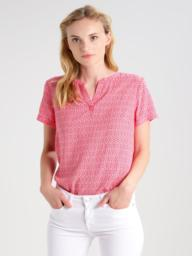

In [29]:
Image(test_img_file)

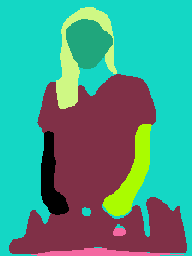

In [30]:
Image(test_label_file)

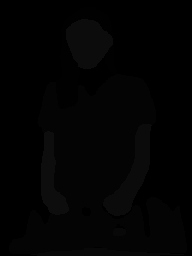

In [31]:
Image(test_label_file.replace('.png','_gray.png'))

In [32]:
test_img_file   = '../Dataset/test_img/003935_0.jpg'
test_label_file = '../Dataset/test_label/003935_0.png'
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.5600,  6.7935,  7.5266,  ...,  7.4150,  6.7116,  5.9406],
          [ 6.8105,  8.6348,  9.6303,  ...,  9.5083,  8.5580,  7.2420],
          [ 7.4346,  9.4388, 10.5740,  ..., 10.3452,  9.2833,  7.7483],
          ...,
          [ 5.6323,  6.5498,  6.9447,  ...,  4.4470,  4.2524,  4.3448],
          [ 5.2277,  6.0228,  6.4929,  ...,  4.1215,  3.9556,  4.1324],
          [ 5.1717,  5.6427,  5.9775,  ...,  4.0801,  4.0003,  4.2704]],

         [[-0.6261, -0.4074, -0.3351,  ...,  0.3237,  0.2611, -0.2585],
          [-0.5122, -0.8659, -0.8460,  ...,  0.1379,  0.3304,  0.1061],
          [-0.5873, -0.9282, -0.9534,  ...,  0.1266,  0.2553,  0.3012],
          ...,
          [-0.8814, -1.3216, -1.5685,  ..., -3.1549, -2.7335, -2.0934],
          [-0.8839, -1.2111, -1.3946,  ..., -3.2101, -2.7732, -2.1700],
          [-1.0560, -1.0320, -1.0427,  ..., -2.7107, -2.4043, -1.9135]],

         [[-3.4247, -3.4908, -3.4822,  ..., -3.5442, -3.5178, -3.4952],
          [-3.6237, -4.0135, -

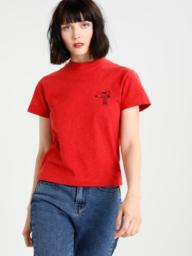

In [33]:
Image(test_img_file)

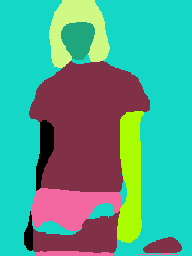

In [34]:
Image(test_label_file)

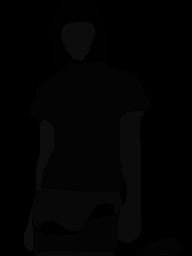

In [35]:
Image(test_label_file.replace('.png','_gray.png'))

In [36]:
test_img_file   = '../Dataset/test_img/000010_0.jpg'
test_label_file = '../Dataset/test_label/000010_0.png'
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.6958,  7.0950,  7.8815,  ...,  6.7541,  6.2295,  5.6757],
          [ 7.1125,  9.0838, 10.2051,  ...,  8.5964,  7.8277,  6.7728],
          [ 7.7747, 10.0154, 11.2192,  ...,  9.1686,  8.4176,  7.2052],
          ...,
          [ 4.6701,  4.9507,  5.2295,  ...,  5.8174,  5.5731,  5.3496],
          [ 4.4555,  4.6592,  4.8979,  ...,  5.4012,  5.1409,  5.0539],
          [ 4.6171,  4.7670,  4.9266,  ...,  5.0542,  4.9121,  4.8519]],

         [[-0.4901, -0.2721, -0.2693,  ...,  0.4540,  0.2529, -0.2569],
          [-0.3971, -0.8629, -1.0040,  ...,  0.5172,  0.5304,  0.0761],
          [-0.5124, -0.9960, -1.1839,  ...,  0.6401,  0.6646,  0.3252],
          ...,
          [-1.5106, -2.0760, -2.3134,  ..., -3.3724, -2.9038, -2.1130],
          [-1.6104, -2.1807, -2.4108,  ..., -3.4379, -2.9369, -2.1293],
          [-1.6415, -1.9205, -2.0625,  ..., -2.6896, -2.3415, -1.8206]],

         [[-3.4531, -3.5725, -3.6156,  ..., -3.4192, -3.3862, -3.4313],
          [-3.6886, -4.2233, -

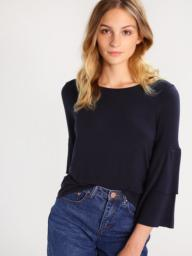

In [37]:
Image(test_img_file)

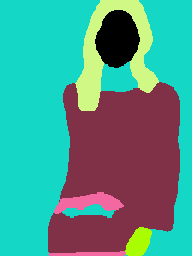

In [38]:
Image(test_label_file)

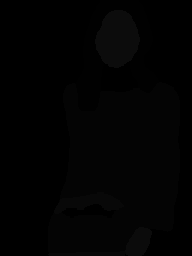

In [39]:
Image(test_label_file.replace('.png','_gray.png'))

In [40]:
test_img_file   = '../Dataset/test_img/000020_0.jpg'
test_label_file = '../Dataset/test_label/000020_0.png'
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.3058,  6.3921,  7.1293,  ...,  7.2194,  6.4939,  5.7658],
          [ 6.4311,  8.1073,  9.0448,  ...,  9.2999,  8.2666,  7.0143],
          [ 7.0067,  8.8342,  9.8100,  ..., 10.0014,  8.9596,  7.5027],
          ...,
          [ 5.0331,  5.4925,  5.5929,  ...,  4.3080,  4.0972,  4.3693],
          [ 4.7659,  5.1059,  5.2499,  ...,  4.0221,  3.8680,  4.1811],
          [ 4.8504,  5.0837,  5.1922,  ...,  4.0476,  3.9749,  4.2952]],

         [[-0.5478, -0.2693, -0.2463,  ...,  0.5181,  0.3832, -0.2031],
          [-0.3587, -0.6419, -0.7530,  ...,  0.5366,  0.6163,  0.1559],
          [-0.3937, -0.7827, -0.8223,  ...,  0.5841,  0.6687,  0.4130],
          ...,
          [-1.0003, -1.3453, -1.5362,  ..., -2.4759, -2.1457, -1.7636],
          [-1.0735, -1.3710, -1.5195,  ..., -2.5609, -2.1931, -1.8170],
          [-1.2646, -1.3593, -1.4030,  ..., -2.2318, -1.9749, -1.6482]],

         [[-3.3908, -3.3908, -3.4236,  ..., -3.5314, -3.4555, -3.4507],
          [-3.5126, -3.7814, -

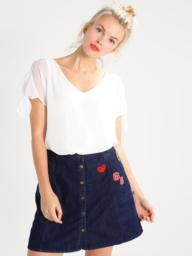

In [41]:
Image(test_img_file)

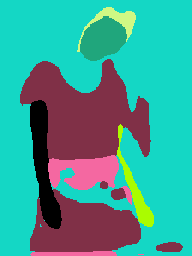

In [42]:
Image(test_label_file)

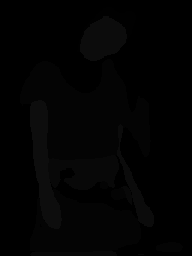

In [43]:
Image(test_label_file.replace('.png','_gray.png'))

# Gray Label to overwrite color label as test_label .png

In [44]:
!mv ../Dataset/test_label/000000_0_gray.png ../Dataset/test_label/000000_0.png

mv: cannot stat '../Dataset/test_label/000000_0_gray.png': No such file or directory


In [45]:
%cd /kaggle/working

/kaggle/working


# Pose Detection: [PoseNet](https://arxiv.org/abs/1505.07427)

In [46]:
!pip install tfjs-graph-converter

     |████████████████████████████████| 77 kB 1.1 MB/s 
     |████████████████████████████████| 40 kB 2.6 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successfully uninstalled packaging-20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.2.3 requires tornado>=5.1, but you have tornado 5.0.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### PoseNet-PyTorch

In [47]:
!git clone https://github.com/rwightman/posenet-pytorch  # fix bugs
%cd posenet-pytorch

Cloning into 'posenet-pytorch'...
remote: Enumerating objects: 115, done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (115/115), 34.73 KiB | 602.00 KiB/s, done.
Resolving deltas: 100% (62/62), done.
/kaggle/working/posenet-pytorch


In [48]:
file = '../Dataset/test_img/000001_0.jpg'

In [49]:
import torch
from posenet.constants import *
from posenet.decode_multi import decode_multiple_poses
from posenet.models.model_factory import load_model
from posenet.utils import *

net = load_model(101)
net = net.cuda()
output_stride = net.output_stride
scale_factor = 1.0

input_image, draw_image, output_scale = posenet.read_imgfile(file, scale_factor=scale_factor, output_stride=output_stride)

Cannot find models file ./_models/mobilenet_v1_101.pth, converting from tfjs...
Weights for checkpoint mobilenet_v1_101 are not downloaded. Downloading to /tmp/_posenet_weights ...


In [50]:
import torch
from posenet.constants import *
from posenet.decode_multi import decode_multiple_poses
from posenet.models.model_factory import load_model
from posenet.utils import *

net = load_model(101)
net = net.cuda()
output_stride = net.output_stride
scale_factor = 1.0

input_image, draw_image, output_scale = posenet.read_imgfile(file, scale_factor=scale_factor, output_stride=output_stride)

## Detect Pose keypoints

In [51]:
import torch
with torch.no_grad():
    input_image = torch.Tensor(input_image).cuda()

    heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = net(input_image)

    pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
        heatmaps_result.squeeze(0),
        offsets_result.squeeze(0),
        displacement_fwd_result.squeeze(0),
        displacement_bwd_result.squeeze(0),
        output_stride=output_stride,
        max_pose_detections=10,
        min_pose_score=0.25)

### find keypoint coordinates in poses

In [52]:
import matplotlib.pyplot as plt
# read image
image = plt.imread(file)

poses = []
# find face keypoints & detect face mask
for pi in range(len(pose_scores)):
    if pose_scores[pi] != 0.:
        print('Pose #%d, score = %f' % (pi, pose_scores[pi]))       
        keypoints = keypoint_coords.astype(np.int32) # convert float to integer
        print(keypoints[pi])
        poses.append(keypoints[pi])
print(len(poses))

Pose #0, score = 0.675167
[[ 31 109]
 [ 24 119]
 [ 23 103]
 [ 34 133]
 [ 29  95]
 [ 87 132]
 [ 76  76]
 [152 142]
 [145  63]
 [216 132]
 [192  51]
 [206 111]
 [202  75]
 [266  76]
 [264  42]
 [262  65]
 [263  25]]
1


### show PoseNet keypoints

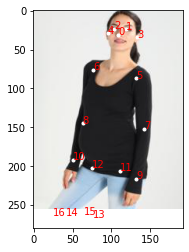

In [53]:
img = plt.imread(file)
i=0
pose = poses[0]
plt.imshow(img)    
for y,x in pose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1   
plt.show()

### PoseNet output
![](https://debuggercafe.com/wp-content/uploads/2020/10/keypoint_exmp.jpg)

### OpenPose COCO format
![](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/.github/media/keypoints_pose_18.png?raw=true)

## Convert Keypoints (from PoseNet to OpenPose)

In [54]:
# map rccpose-to-openpose mapping
indices = [0, (5,6), 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]

In [55]:
# convert rcnnpose to openpose
i=0
openpose = []
for ix in indices:
    if ix==(5,6):
        openpose.append([int((pose[5][1]+pose[6][1])/2), int((pose[5][0]+pose[6][0])/2), 1])   
    else:
        openpose.append([int(pose[ix][1]),int(pose[ix][0]),1])        
    i+=1
    
print(openpose)

[[109, 31, 1], [104, 81, 1], [76, 76, 1], [63, 145, 1], [51, 192, 1], [132, 87, 1], [142, 152, 1], [132, 216, 1], [75, 202, 1], [42, 264, 1], [25, 263, 1], [111, 206, 1], [76, 266, 1], [65, 262, 1], [103, 23, 1], [119, 24, 1], [95, 29, 1], [133, 34, 1]]


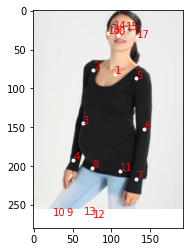

In [56]:
plt.imshow(img)
i=0
for x,y,z in openpose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()

### save keypoints.json

In [57]:
import json
coords = []
for x,y,z in openpose:
    coords.append(float(x))
    coords.append(float(y))
    coords.append(float(z))

data = {"version": 1.0}
pose_dic = {}
pose_dic['pose_keypoints'] = coords
tmp = []
tmp.append(pose_dic)
data["people"]=tmp
print(data)

pose_name = '../Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name,'w') as f:
     json.dump(data, f)  

{'version': 1.0, 'people': [{'pose_keypoints': [109.0, 31.0, 1.0, 104.0, 81.0, 1.0, 76.0, 76.0, 1.0, 63.0, 145.0, 1.0, 51.0, 192.0, 1.0, 132.0, 87.0, 1.0, 142.0, 152.0, 1.0, 132.0, 216.0, 1.0, 75.0, 202.0, 1.0, 42.0, 264.0, 1.0, 25.0, 263.0, 1.0, 111.0, 206.0, 1.0, 76.0, 266.0, 1.0, 65.0, 262.0, 1.0, 103.0, 23.0, 1.0, 119.0, 24.0, 1.0, 95.0, 29.0, 1.0, 133.0, 34.0, 1.0]}]}


## Verify _keypoints.json

In [58]:
%cd /kaggle/working

/kaggle/working


### read .json

In [59]:
# read pose
import numpy as np
import json
#pose_name = '/kaggle/input/tryon-testdata/Dataset/test_pose/000000_0_keypoints.json'
pose_name = 'Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name, 'r') as f:
     pose_label = json.load(f)
     pose_data = pose_label['people'][0]['pose_keypoints']
     pose_data = np.array(pose_data)
     pose_data = pose_data.reshape((-1,3))
print(pose_data)
print(len(pose_data))

[[109.  31.   1.]
 [104.  81.   1.]
 [ 76.  76.   1.]
 [ 63. 145.   1.]
 [ 51. 192.   1.]
 [132.  87.   1.]
 [142. 152.   1.]
 [132. 216.   1.]
 [ 75. 202.   1.]
 [ 42. 264.   1.]
 [ 25. 263.   1.]
 [111. 206.   1.]
 [ 76. 266.   1.]
 [ 65. 262.   1.]
 [103.  23.   1.]
 [119.  24.   1.]
 [ 95.  29.   1.]
 [133.  34.   1.]]
18


### draw keypoints 

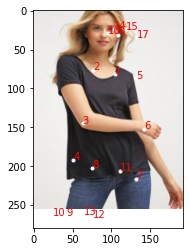

18


In [60]:
# show pose keypoints on the test image
file = 'Dataset/test_img/000000_0.jpg'
img = plt.imread(file)
plt.imshow(img)
i=0
for x,y,z in pose_data: 
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()
print(i)

# Try ON

In [61]:
!git clone https://github.com/rkuo2000/DeepFashion_Try_On
%cd DeepFashion_Try_On

Cloning into 'DeepFashion_Try_On'...
remote: Enumerating objects: 261, done.
remote: Total 261 (delta 0), reused 0 (delta 0), pack-reused 261
Receiving objects: 100% (261/261), 13.46 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/kaggle/working/DeepFashion_Try_On


### Download pre-trained model (checkpoint)

In [62]:
%cd ACGPN_inference

/kaggle/working/DeepFashion_Try_On/ACGPN_inference


In [63]:
# copy the pre-trained model (checkpoint)
!cp -rf /kaggle/input/acgpn-checkpoints/label2city checkpoints

## Test TryOn model 

In [64]:
!python test.py --dataroot ../../Dataset --color_name 000129_1.jpg

?
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
color_name: 000129_1.jpg
continue_train: False
data_type: 32
dataroot: ../../Dataset
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLo

#### output : sample/000000_0.jpg

### Display TryOn result

In [65]:
!mkdir -p ../Data_preprocessing

In [66]:
!cp -rf /kaggle/input/viton-dataset/ACGPN_TestData/* ../Data_preprocessing

In [67]:
!ls ../Data_preprocessing

readme.txt  test_colormask  test_img	test_mask
test_color  test_edge	    test_label	test_pose


# Model Modified Outputs

In [68]:

!cp -rf /kaggle/input/acgpn-checkpoints/label2city checkpoints

In [69]:
!python test.py

?
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
color_name: 014379_1.jpg
continue_train: False
data_type: 32
dataroot: ../Data_preprocessing/
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomData

## Results

In [70]:
!ls sample

000001_0.jpg  003935_0.jpg  007856_0.jpg  011781_0.jpg	015707_0.jpg
000010_0.jpg  003945_0.jpg  007864_0.jpg  011790_0.jpg	015715_0.jpg
000020_0.jpg  003953_0.jpg  007874_0.jpg  011798_0.jpg	015724_0.jpg
000028_0.jpg  003963_0.jpg  007882_0.jpg  011806_0.jpg	015732_0.jpg
000038_0.jpg  003972_0.jpg  007891_0.jpg  011816_0.jpg	015740_0.jpg
000048_0.jpg  003981_0.jpg  007899_0.jpg  011825_0.jpg	015748_0.jpg
000057_0.jpg  003990_0.jpg  007914_0.jpg  011833_0.jpg	015759_0.jpg
000066_0.jpg  003998_0.jpg  007923_0.jpg  011842_0.jpg	015767_0.jpg
000074_0.jpg  004006_0.jpg  007932_0.jpg  011850_0.jpg	015776_0.jpg
000082_0.jpg  004015_0.jpg  007940_0.jpg  011862_0.jpg	015785_0.jpg
000097_0.jpg  004023_0.jpg  007949_0.jpg  011872_0.jpg	015794_0.jpg
000109_0.jpg  004033_0.jpg  007957_0.jpg  011883_0.jpg	015803_0.jpg
000118_0.jpg  004042_0.jpg  007966_0.jpg  011891_0.jpg	015816_0.jpg
000129_0.jpg  004051_0.jpg  007974_0.jpg  011899_0.jpg	015825_0.jpg
000143_0.jpg  004061_0.jpg  007986_0.jpg  011908

#### Display sample images

In [71]:
from IPython.display import Image

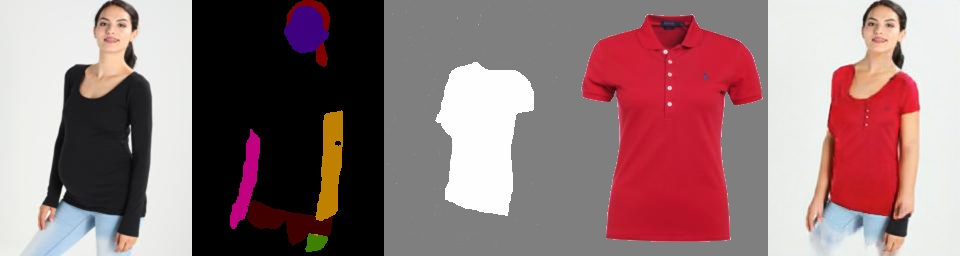

In [72]:
Image('sample/000001_0.jpg')

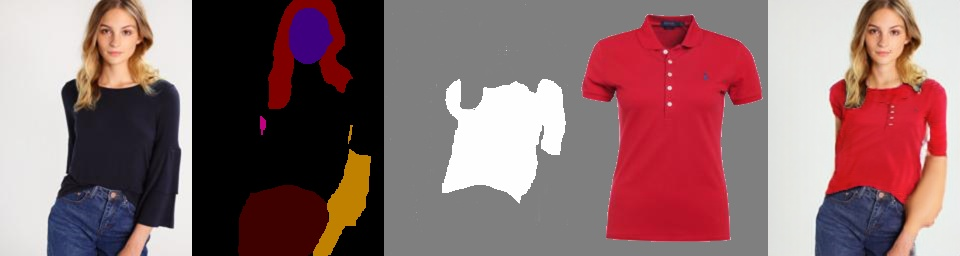

In [73]:
Image('sample/000010_0.jpg')


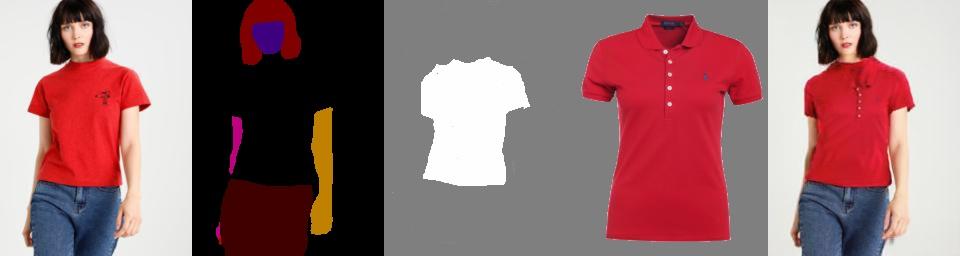

In [74]:
Image('sample/003935_0.jpg')

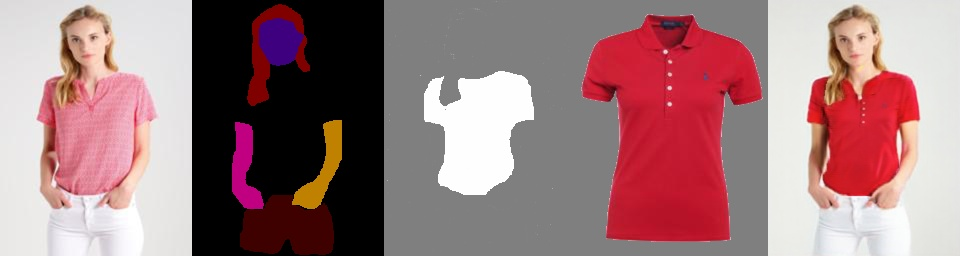

In [75]:
Image('sample/003821_0.jpg') 

In [76]:
dir = '/content/drive/MyDrive/DeOldify/Project7/Denoising '
all_img = []
for dir_path,_,filenames in os.walk(dir):
  all_img.append(filenames)


### Current Dir Location

In [77]:
import os
directory = os.getcwd()
print(directory)

/kaggle/working/DeepFashion_Try_On/ACGPN_inference


In [78]:
dir = '/kaggle/working/DeepFashion_Try_On/ACGPN_inference/sample/'
results = []
for dir_path,_,filenames in os.walk(dir):
  results.append(filenames)

In [79]:
results = results[0]

In [80]:
results

['002553_0.jpg',
 '004766_0.jpg',
 '012795_0.jpg',
 '010473_0.jpg',
 '001520_0.jpg',
 '005298_0.jpg',
 '000228_0.jpg',
 '017545_0.jpg',
 '003236_0.jpg',
 '010308_0.jpg',
 '010628_0.jpg',
 '008919_0.jpg',
 '009356_0.jpg',
 '002379_0.jpg',
 '006678_0.jpg',
 '000706_0.jpg',
 '000248_0.jpg',
 '017840_0.jpg',
 '000542_0.jpg',
 '018580_0.jpg',
 '007294_0.jpg',
 '014220_0.jpg',
 '009984_0.jpg',
 '006232_0.jpg',
 '002511_0.jpg',
 '016121_0.jpg',
 '013836_0.jpg',
 '016786_0.jpg',
 '011106_0.jpg',
 '007997_0.jpg',
 '012202_0.jpg',
 '010078_0.jpg',
 '007874_0.jpg',
 '000293_0.jpg',
 '003945_0.jpg',
 '002639_0.jpg',
 '012089_0.jpg',
 '008041_0.jpg',
 '010599_0.jpg',
 '011363_0.jpg',
 '008551_0.jpg',
 '012944_0.jpg',
 '007003_0.jpg',
 '011724_0.jpg',
 '017323_0.jpg',
 '003676_0.jpg',
 '001512_0.jpg',
 '013855_0.jpg',
 '000001_0.jpg',
 '017505_0.jpg',
 '003094_0.jpg',
 '016533_0.jpg',
 '008560_0.jpg',
 '014888_0.jpg',
 '009382_0.jpg',
 '006817_0.jpg',
 '009832_0.jpg',
 '001064_0.jpg',
 '012495_0.jpg

In [81]:
!ls

__pycache__  grid_sample.py  one_map.jpg  sample	   util
checkpoints  im_pose.jpg     options	  test.py
data	     models	     runs	  tps_grid_gen.py


In [82]:
import random


In [83]:
# for i in range(0,1):
#     print(i)
#     random_result = random.choice(results)
#     Image('sample/'+str(random_result))

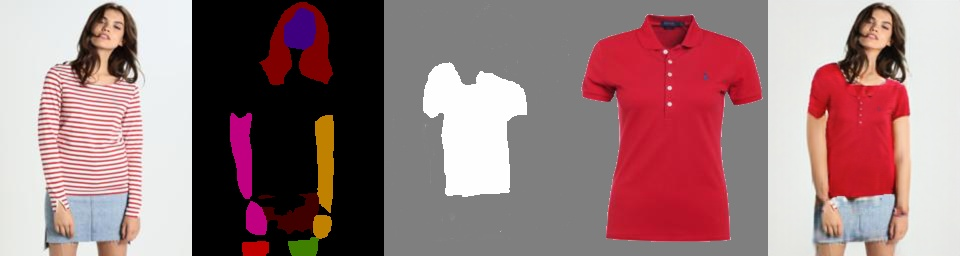

In [84]:
Image('sample/011769_0.jpg')


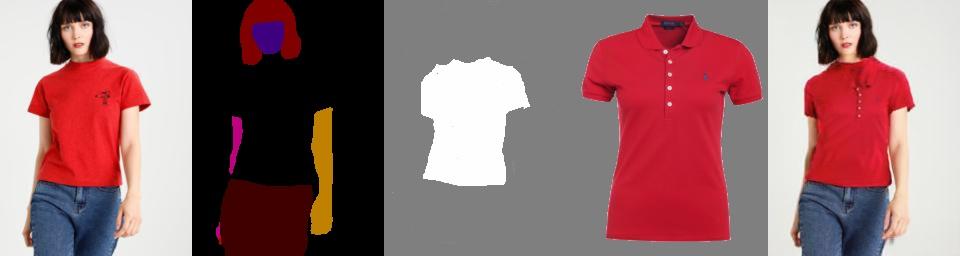

In [85]:
Image('sample/003935_0.jpg')

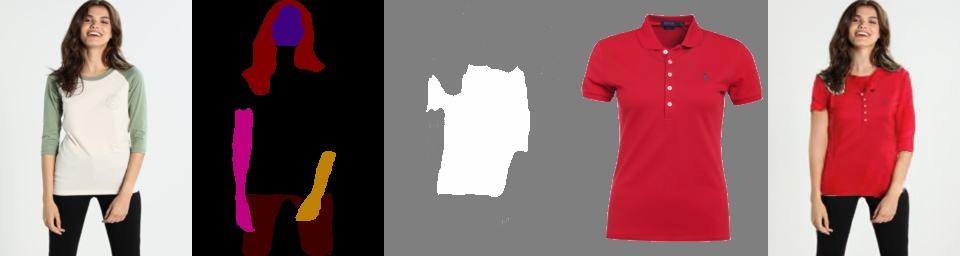

In [86]:

Image('sample/001236_0.jpg')


### Final Model

In [87]:
!git clone https://github.com/switchablenorms/DeepFashion_Try_On
%cd DeepFashion_Try_On

Cloning into 'DeepFashion_Try_On'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 356 (delta 103), reused 131 (delta 74), pack-reused 191
Receiving objects: 100% (356/356), 14.74 MiB | 19.53 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/kaggle/working/DeepFashion_Try_On/ACGPN_inference/DeepFashion_Try_On


In [88]:
%cd ACGPN_inference

/kaggle/working/DeepFashion_Try_On/ACGPN_inference/DeepFashion_Try_On/ACGPN_inference


In [89]:
!mkdir -p ../Data_preprocessing

In [90]:
!cp -rf /kaggle/input/viton-dataset/ACGPN_TestData/* ../Data_preprocessing

In [91]:
!ls ../Data_preprocessing

readme.txt  test_colormask  test_img	test_mask
test_color  test_edge	    test_label	test_pose


### trained model (checkpoint)

In [92]:

!cp -rf /kaggle/input/acgpn-checkpoints/label2city checkpoints

### Virtual Fit

In [93]:
!python test.py

?
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
data_type: 32
dataroot: ../Data_preprocessing/
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [Al

In [94]:
!ls sample

000001_0.jpg  003935_0.jpg  007856_0.jpg  011781_0.jpg	015707_0.jpg
000010_0.jpg  003945_0.jpg  007864_0.jpg  011790_0.jpg	015715_0.jpg
000020_0.jpg  003953_0.jpg  007874_0.jpg  011798_0.jpg	015724_0.jpg
000028_0.jpg  003963_0.jpg  007882_0.jpg  011806_0.jpg	015732_0.jpg
000038_0.jpg  003972_0.jpg  007891_0.jpg  011816_0.jpg	015740_0.jpg
000048_0.jpg  003981_0.jpg  007899_0.jpg  011825_0.jpg	015748_0.jpg
000057_0.jpg  003990_0.jpg  007914_0.jpg  011833_0.jpg	015759_0.jpg
000066_0.jpg  003998_0.jpg  007923_0.jpg  011842_0.jpg	015767_0.jpg
000074_0.jpg  004006_0.jpg  007932_0.jpg  011850_0.jpg	015776_0.jpg
000082_0.jpg  004015_0.jpg  007940_0.jpg  011862_0.jpg	015785_0.jpg
000097_0.jpg  004023_0.jpg  007949_0.jpg  011872_0.jpg	015794_0.jpg
000109_0.jpg  004033_0.jpg  007957_0.jpg  011883_0.jpg	015803_0.jpg
000118_0.jpg  004042_0.jpg  007966_0.jpg  011891_0.jpg	015816_0.jpg
000129_0.jpg  004051_0.jpg  007974_0.jpg  011899_0.jpg	015825_0.jpg
000143_0.jpg  004061_0.jpg  007986_0.jpg  011908

### Final Results

In [95]:
from IPython.display import Image

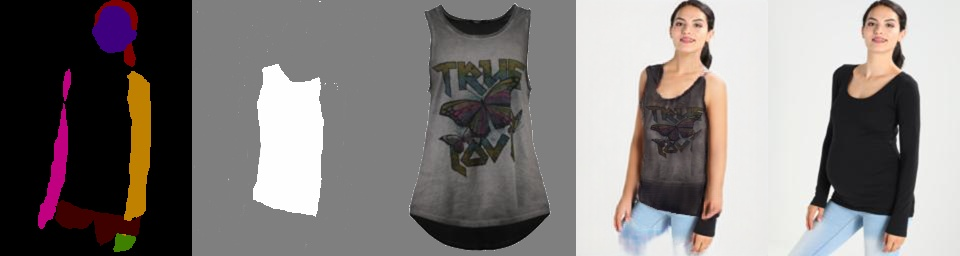

In [96]:
Image('sample/000001_0.jpg')

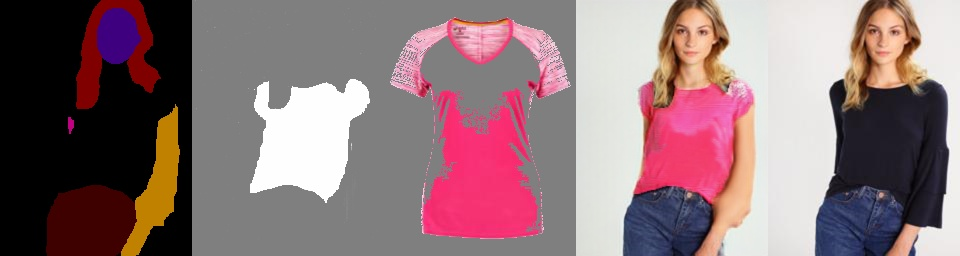

In [97]:
Image('sample/000010_0.jpg')

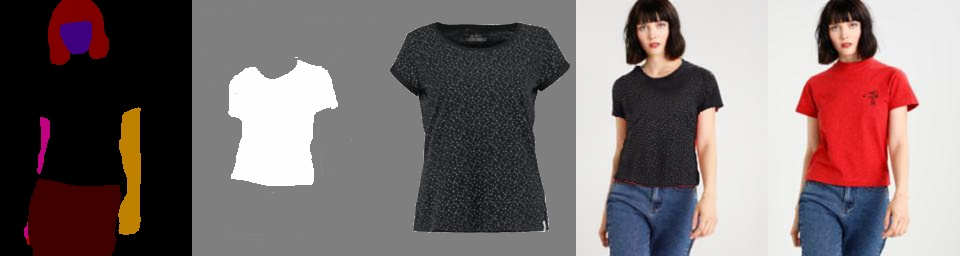

In [98]:
Image('sample/003935_0.jpg')

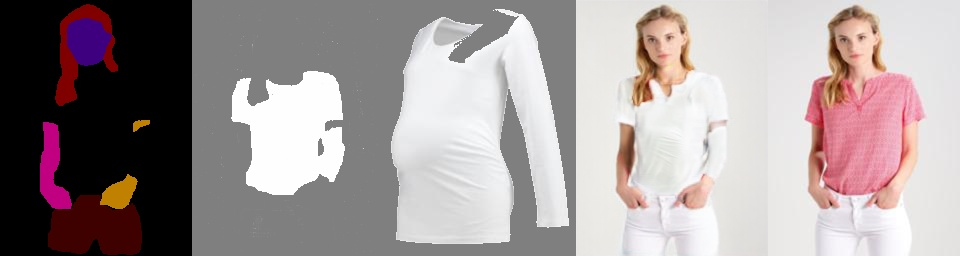

In [99]:
Image('sample/003821_0.jpg')

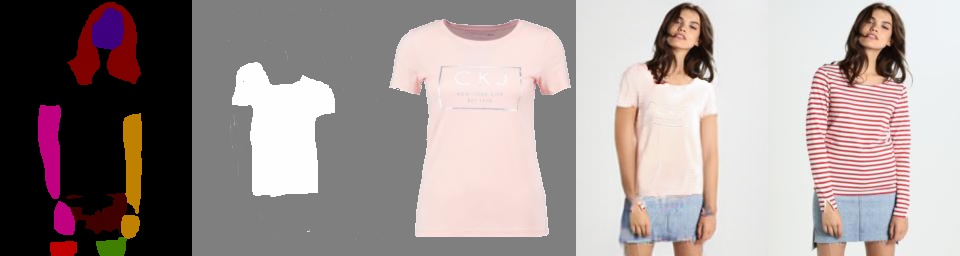

In [100]:
Image('sample/011769_0.jpg')

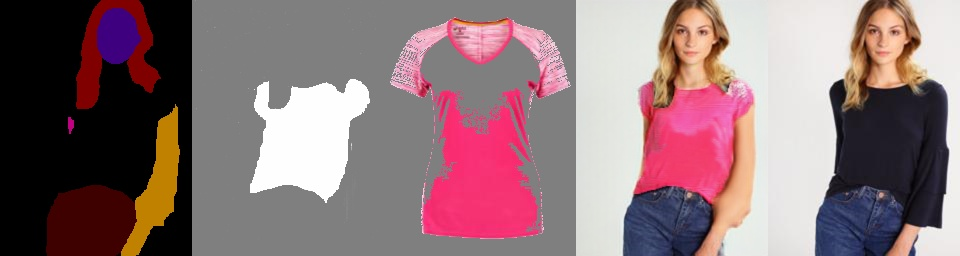

In [101]:
Image('sample/000010_0.jpg')

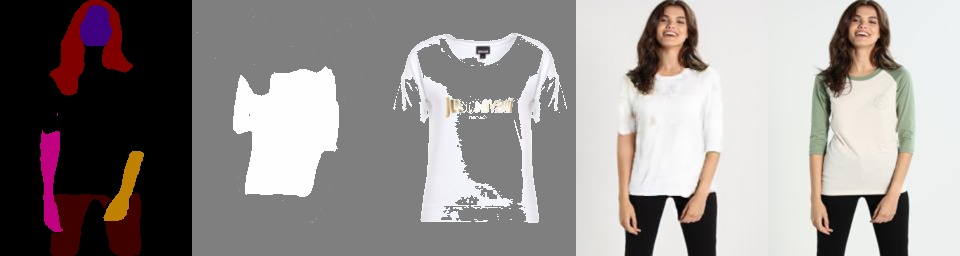

In [102]:
Image('sample/001236_0.jpg')

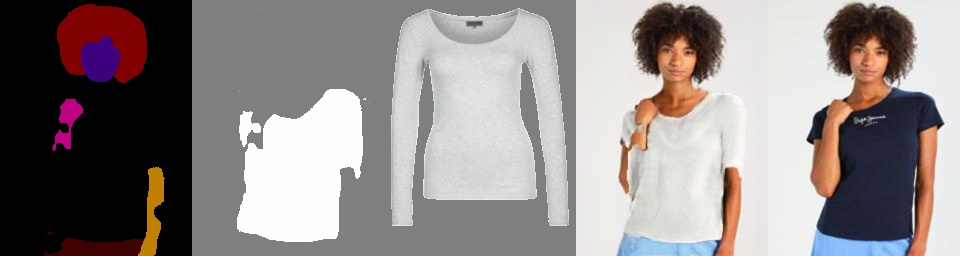

In [103]:
Image('sample/015697_0.jpg')

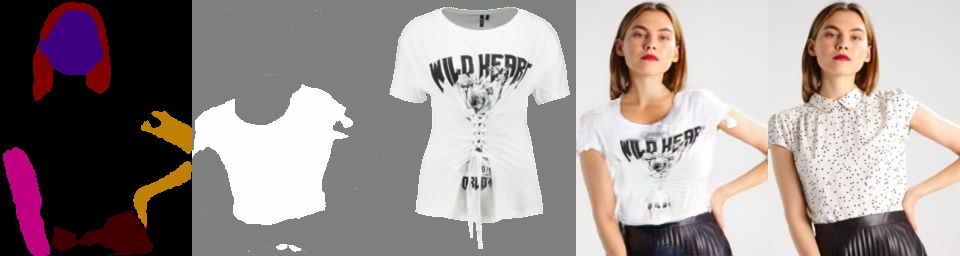

In [104]:
Image('sample/015869_0.jpg')

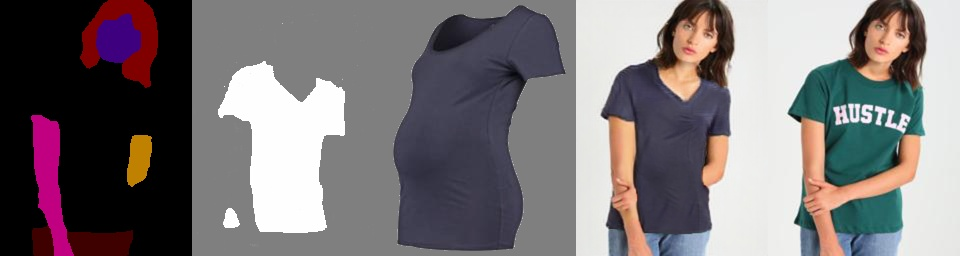

In [105]:
Image('sample/000192_0.jpg')

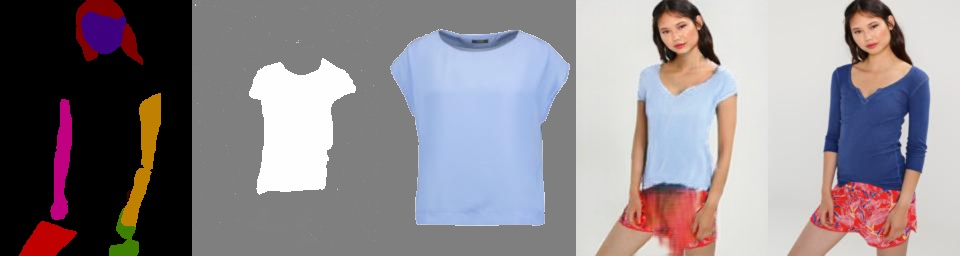

In [106]:
Image('sample/004107_0.jpg')

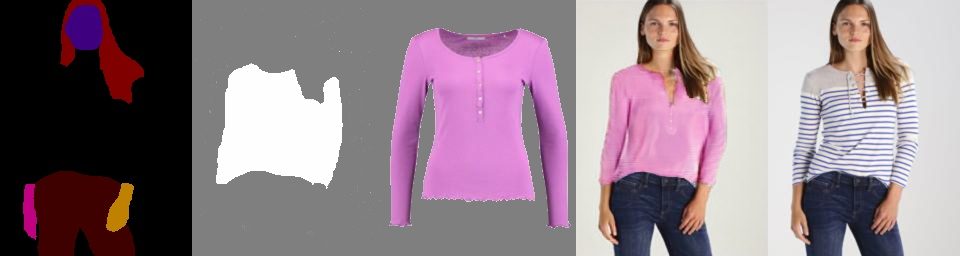

In [107]:
Image('sample/008032_0.jpg')

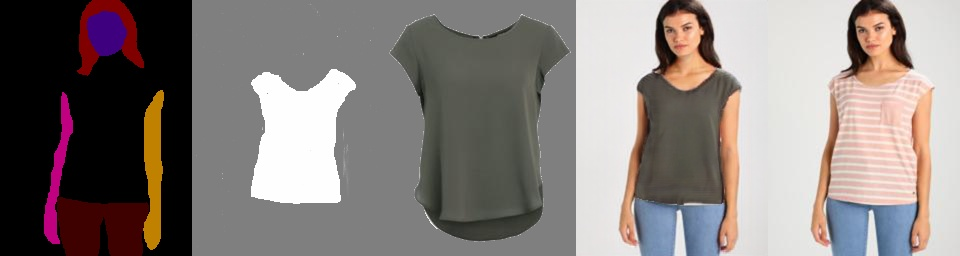

In [108]:
Image('sample/011954_0.jpg')

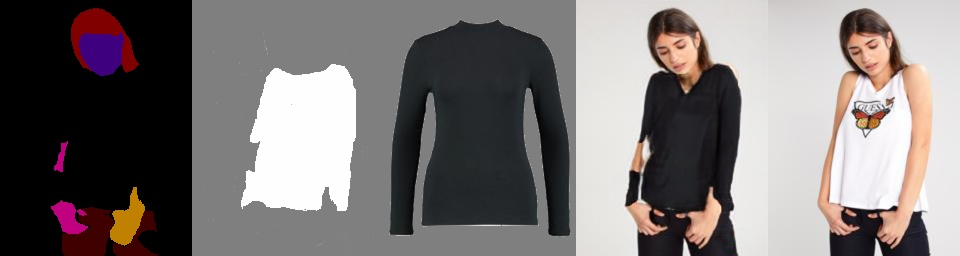

In [109]:
Image('sample/015881_0.jpg')

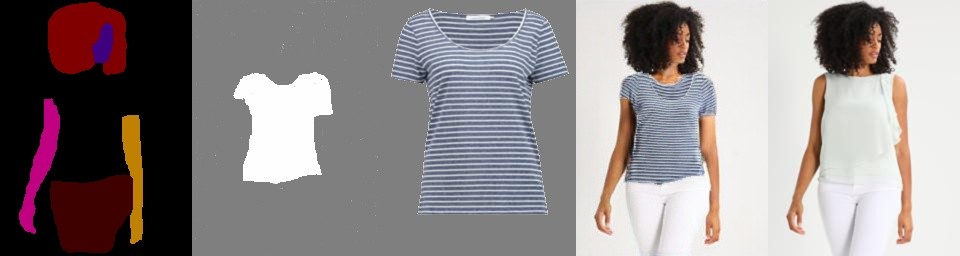

In [110]:
Image('sample/019486_0.jpg')

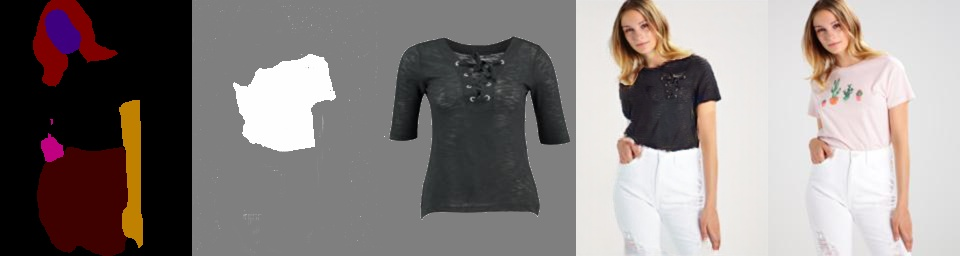

In [111]:
Image('sample/019279_0.jpg')

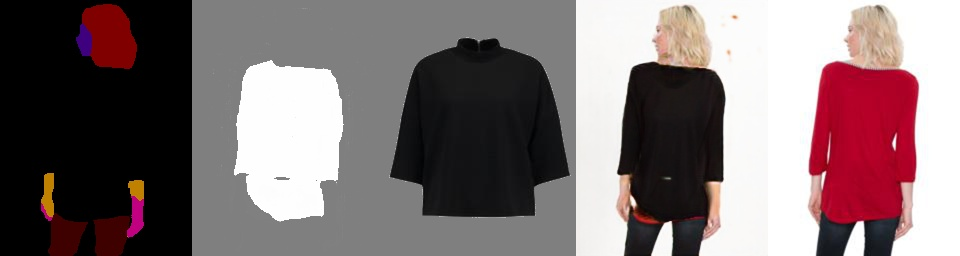

In [112]:
Image('sample/015141_0.jpg')

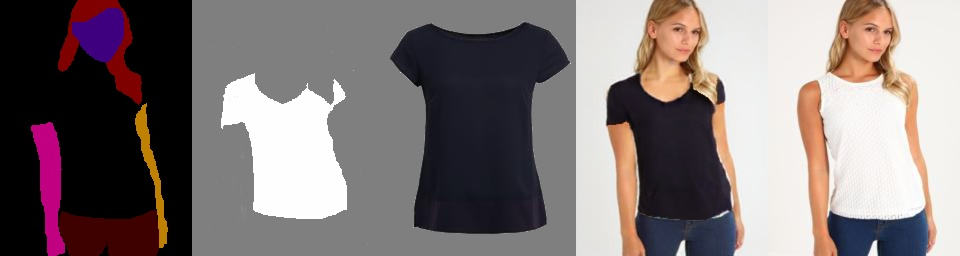

In [113]:
Image('sample/003514_0.jpg')

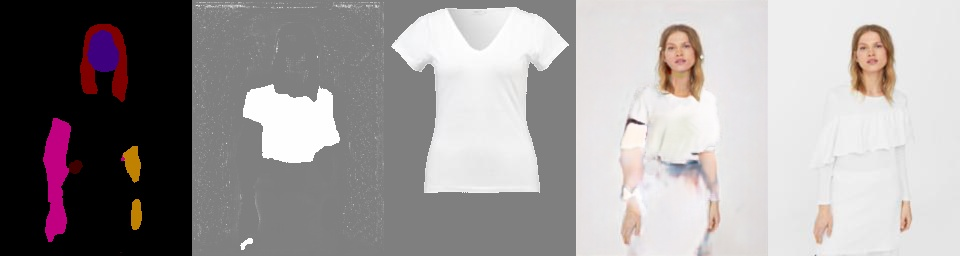

In [114]:
Image('sample/009454_0.jpg')

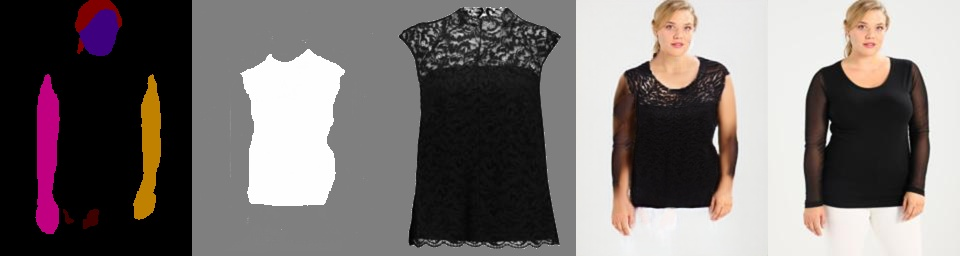

In [115]:
Image('sample/001448_0.jpg')

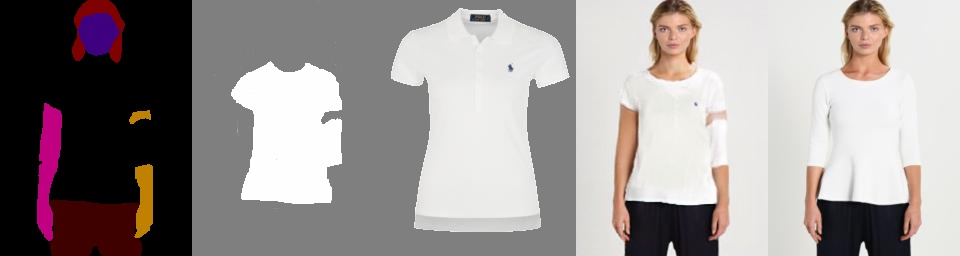

In [116]:
Image('sample/010984_0.jpg')